This notebook uses the halo hot water output of the gulfstream AOI and uses ocetrac to compute vector marine heatwaves.

In [19]:
import glob

import xarray as xr
import ocetrac
from dask.distributed import Client
import dask

## Load hotwater

In [12]:
hot_water = xr.open_dataset('/data/pacific/rwegener/gulfstream_hotwater.nc')

hot_water = hot_water.hot_water

In [13]:
hot_water

<xarray.DataArray 'hot_water' (time: 7134, lat: 420, lon: 740)>
[2217247200 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 32.03 32.08 32.12 32.17 ... 52.83 52.88 52.92 52.97
  * lon      (lon) float32 -78.97 -78.93 -78.88 -78.82 ... -42.12 -42.08 -42.03
  * time     (time) datetime64[ns] 2002-09-01T12:00:00 ... 2022-03-20T12:00:00
Attributes:
    description:      nan values in all pixels that were not experiencing a m...
    date created:     2022-05-23
    source datasets:  ['Geopolar SST', 'anomaly', 'threshold']

## Create land mask

In [9]:
climatology = xr.open_dataset('/data/pacific/rwegener/gulfstream_climatology.nc')

In [10]:
oneday = climatology.climatology.isel(time=0)
mask = xr.where(oneday==0, 0, 1)

## Run ocetrac

In [34]:
# Doesn't seem to use dask (waiting ~5 minutes with no activity)
# dask.config.set(temporary_directory='/data/pacific/rwegener')
# client = Client()

Ocetrac arg errors:
- `xdim = 'x', ydim='y', ` -> MemoryError: Unable to allocate 2.45 PiB for an array with shape (7134, 420, 740, 420, 740) and data type float32 (which is fair)

In [35]:
Tracker = ocetrac.Tracker(hot_water, mask, radius=2, min_size_quartile=0.75, 
                          timedim = 'time', xdim = 'lon', ydim='lat', positive=True)

Timing: Wall time 34 minutes, CPU time 19 min, sys time 15 min
- started: 10:50
- ended at or before: 11:25

In [36]:
%%time

blobs = Tracker.track()

minimum area: 322.0
inital objects identified 	 220550
final objects tracked 	 8279
CPU times: user 18min 53s, sys: 15min 21s, total: 34min 14s
Wall time: 34min 14s


In [38]:
blobs.to_dataset(name='blobs').to_netcdf('/data/pacific/rwegener/gulfstream_blobs.nc')

In [39]:
blobs

<xarray.DataArray 'labels' (time: 7134, lat: 420, lon: 740)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float32 32.03 32.08 32.12 32.17 ... 52.83 52.88 52.92 52.97
  * lon      (lon) float32 -78.97 -78.93 -78.88 -78.82 ... -42.12 -42.08 -42.03
  * time     (time) datetime64[ns] 2002-09-01T12:00:00 ... 2022-03-20T12:00:00
Attributes:
    inital objects identified:  220550
    final objects tracked:      8279
    radius:                     2
    size quantile threshold:    0.75
    min area:                   322.0
    percent area reject:        0.08480810672360123
    percent area accept:        0.9151918932763988

In [1]:
import imageio
import os

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [4]:
blobs = xr.open_dataset('/data/pacific/rwegener/gulfstream_blobs.nc')
blobs = blobs.blobs

In [6]:
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())

In [29]:
def ocetrac_plot(index):
    plt.figure(figsize=(16,3))
    ax1 = plt.subplot(121)
    blobs.isel(time=index).plot(cmap=cm, vmin=0, vmax=maxl)
    mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False)
    ax1.set_aspect('equal')
    ax2 = plt.subplot(122)
    hot_water.isel(time=index).plot(cmap='Reds', vmin=0, vmax=16)
    mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False)
    ax2.set_aspect('equal')

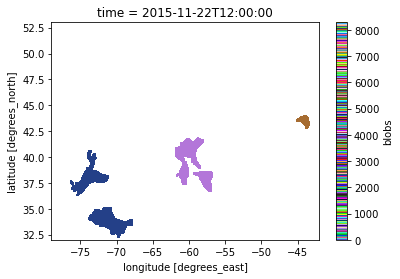

In [33]:
blobs.isel(time=4830).plot(cmap= cm, vmin=0, vmax=maxl)
# mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False)

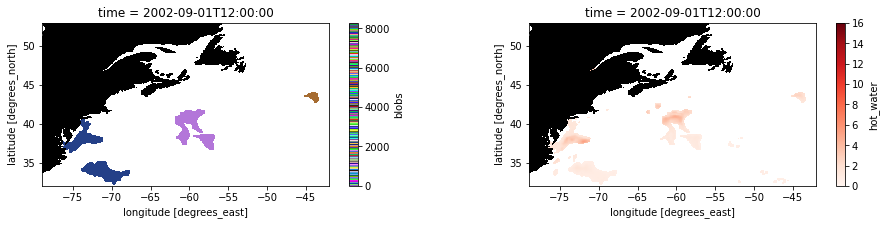

In [30]:
ocetrac_plot(4830)

In [16]:
filenames = []
# if not os.path.exists('./scratch'):
#     os.makedirs('./scratch')

for i in range(4830, len(blobs.time)):
    ocetrac_plot(i)
    filepath = f"./scratch/{i}.png"
    plt.savefig(filepath, bbox_inches='tight')
    plt.close()
    filenames.append(filepath)

In [21]:
# Build GIF
# TODO create a new list of file names 
filenames = glob.glob('./scratch/*.png')
with imageio.get_writer('./gulfstream_blobs_25fps.mp4', mode='I', fps=25) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (886, 225) to (896, 240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
